In [ ]:
import numpy as np
from google.colab import drive

drive.mount('/content/drive')
%cd /content/drive/MyDrive/project

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/project


In [1]:
import numpy as np
from keras.models import Sequential
from keras.utils import to_categorical
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,BatchNormalization,MaxPooling2D,Reshape
import keras
X_test = np.load("X_test.npy")
y_test_1 = np.load("y_test.npy")  # changed from y_test
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

2023-03-17 09:46:20.712231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Shape of data

https://www.bbci.de/competition/iv/desc_2a.pdf

In [2]:
print ('Training/Valid data shape: {}'.format(X_train_valid.shape))
print ('Test data shape: {}'.format(X_test.shape))
print ('Training/Valid target shape: {}'.format(y_train_valid.shape))
print ('Test target shape: {}'.format(y_test_1.shape))  # changed from y_test
print ('Person train/valid shape: {}'.format(person_train_valid.shape))
print ('Person test shape: {}'.format(person_test.shape))
p_train=list(person_train_valid.reshape((person_train_valid.shape[0])))
p_test=list(person_test.reshape((person_test.shape[0])))
subject1tr=p_train.index(1)-1
subject1te=p_test.index(1)-1
subject1_x_train=X_train_valid[0:subject1tr+1].copy()
subject1_y_train=y_train_valid[0:subject1tr+1].copy()

subject1_x_test=X_test[0:subject1te+1].copy()
subject1_y_test=y_test_1[0:subject1te+1].copy()

y_train_valid -= 769
y_test_1 -= 769  # changed from y_test
subject1_y_train-=769
subject1_y_test-=769

Training/Valid data shape: (2115, 22, 1000)
Test data shape: (443, 22, 1000)
Training/Valid target shape: (2115,)
Test target shape: (443,)
Person train/valid shape: (2115, 1)
Person test shape: (443, 1)


In [3]:
def data_prep(X,y,sub_sample,average,noise):
    
    total_X = None
    total_y = None
    
    # Trimming the data (sample,22,1000) -> (sample,22,500)
    X = X[:,:,0:500]
    print('Shape of X after trimming:',X.shape)
    
    # Maxpooling the data (sample,22,1000) -> (sample,22,500/sub_sample)
    X_max = np.max(X.reshape(X.shape[0], X.shape[1], -1, sub_sample), axis=3)
    
    
    total_X = X_max
    total_y = y
    print('Shape of X after maxpooling:',total_X.shape)
    
    # Averaging + noise 
    X_average = np.mean(X.reshape(X.shape[0], X.shape[1], -1, average),axis=3)
    X_average = X_average + np.random.normal(0.0, 0.5, X_average.shape)
    
    total_X = np.vstack((total_X, X_average))
    total_y = np.hstack((total_y, y))
    print('Shape of X after averaging+noise and concatenating:',total_X.shape)
    
    # Subsampling
    
    for i in range(sub_sample):
        
        X_subsample = X[:, :, i::sub_sample] + \
                            (np.random.normal(0.0, 0.5, X[:, :,i::sub_sample].shape) if noise else 0.0)
            
        total_X = np.vstack((total_X, X_subsample))
        total_y = np.hstack((total_y, y))
        
    
    print('Shape of X after subsampling and concatenating:',total_X.shape)
    return total_X,total_y


X_train_valid_prep,y_train_valid_prep = data_prep(X_train_valid, y_train_valid, 2, 2, True)


Shape of X after trimming: (2115, 22, 500)
Shape of X after maxpooling: (2115, 22, 250)
Shape of X after averaging+noise and concatenating: (4230, 22, 250)
Shape of X after subsampling and concatenating: (8460, 22, 250)


In [4]:
ind_valid = np.random.choice(2115, 375, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))

# Creating the training and validation sets using the generated indices
(X_train, X_valid) = X_train_valid[ind_train], X_train_valid[ind_valid] 
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]


## Preprocessing the dataset
x_train,y_train = data_prep(X_train,y_train,2,2,True)
x_valid,y_valid = data_prep(X_valid,y_valid,2,2,True)
X_test_prep,y_test_prep = data_prep(X_test,y_test_1,2,2,True)  # changed from y_test
subject1_x_train,subject1_y_train=data_prep(subject1_x_train,subject1_y_train,2,2,True)
subject1_x_test,subject1_y_test=data_prep(subject1_x_test,subject1_y_test,2,2,True)





print('Shape of testing set:',X_test_prep.shape)
print('Shape of testing labels:',y_test_prep.shape)

print('Shape of training set:',x_train.shape)
print('Shape of validation set:',x_valid.shape)
print('Shape of training labels:',y_train.shape)
print('Shape of validation labels:',y_valid.shape)



# Converting the labels to categorical variables for multiclass classification
y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test_prep, 4)  # leave unchanged from y_test
subject1_y_train=to_categorical(subject1_y_train, 4)
subject1_y_test=to_categorical(subject1_y_test, 4)


print('Shape of training labels after categorical conversion:',y_train.shape)
print('Shape of validation labels after categorical conversion:',y_valid.shape)
print('Shape of test labels after categorical conversion:',y_test.shape)

# Adding width of the segment to be 1
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_train.shape[2], 1)
x_test = X_test_prep.reshape(X_test_prep.shape[0], X_test_prep.shape[1], X_test_prep.shape[2], 1)
subject1_x_train = subject1_x_train.reshape(subject1_x_train.shape[0], subject1_x_train.shape[1], subject1_x_train.shape[2], 1)
subject1_x_test = subject1_x_test.reshape(subject1_x_test.shape[0], subject1_x_test.shape[1], subject1_x_test.shape[2], 1)
print('Shape of training set after adding width info:',x_train.shape)
print('Shape of validation set after adding width info:',x_valid.shape)
print('Shape of test set after adding width info:',x_test.shape)


# Reshaping the training and validation dataset
x_train = np.swapaxes(x_train, 1,3)
x_train = np.swapaxes(x_train, 1,2)
x_valid = np.swapaxes(x_valid, 1,3)
x_valid = np.swapaxes(x_valid, 1,2)
x_test = np.swapaxes(x_test, 1,3)
x_test = np.swapaxes(x_test, 1,2)
subject1_x_test = np.swapaxes(subject1_x_test, 1,3)
subject1_x_test = np.swapaxes(subject1_x_test, 1,2)
subject1_x_train = np.swapaxes(subject1_x_train, 1,3)
subject1_x_train = np.swapaxes(subject1_x_train, 1,2)

print('Shape of training set after dimension reshaping:',x_train.shape)
print('Shape of validation set after dimension reshaping:',x_valid.shape)
print('Shape of test set after dimension reshaping:',x_test.shape)

Shape of X after trimming: (1740, 22, 500)
Shape of X after maxpooling: (1740, 22, 250)
Shape of X after averaging+noise and concatenating: (3480, 22, 250)
Shape of X after subsampling and concatenating: (6960, 22, 250)
Shape of X after trimming: (375, 22, 500)
Shape of X after maxpooling: (375, 22, 250)
Shape of X after averaging+noise and concatenating: (750, 22, 250)
Shape of X after subsampling and concatenating: (1500, 22, 250)
Shape of X after trimming: (443, 22, 500)
Shape of X after maxpooling: (443, 22, 250)
Shape of X after averaging+noise and concatenating: (886, 22, 250)
Shape of X after subsampling and concatenating: (1772, 22, 250)
Shape of X after trimming: (199, 22, 500)
Shape of X after maxpooling: (199, 22, 250)
Shape of X after averaging+noise and concatenating: (398, 22, 250)
Shape of X after subsampling and concatenating: (796, 22, 250)
Shape of X after trimming: (50, 22, 500)
Shape of X after maxpooling: (50, 22, 250)
Shape of X after averaging+noise and concatena

In [ ]:
# https://arxiv.org/pdf/1703.05051.pdf

In [5]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [6]:
head_size = 128
num_heads = 16
dropout  = 0.7

In [ ]:
inputs = layers.Input(shape=(250, 1, 22))

x = layers.Conv2D(filters=50,  kernel_size=(10,1), activation="elu", padding="same")(inputs)
x = layers.MaxPool2D(pool_size=(3,1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)
x = layers.Conv2D(filters=75,  kernel_size=(10,1), activation="elu", padding="same")(x)
x = layers.MaxPool2D(pool_size=(3,1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)
x = layers.Conv2D(filters=100,  kernel_size=(10,1), activation="elu", padding="same")(x)
x = layers.MaxPool2D(pool_size=(3,1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)
x = layers.Conv2D(filters=150, kernel_size=(3,1), activation="elu", padding="same")(x)
x = layers.MaxPool2D(pool_size=(3,1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)
x = layers.Conv2D(filters=200, kernel_size=(3,1), activation="elu", padding="same")(x)
x = layers.MaxPool2D(pool_size=(10,1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)

x = layers.MultiHeadAttention(
    key_dim   = head_size,
    num_heads = num_heads,
    dropout   = 0.7
)(x, x)

x = layers.GlobalMaxPool2D()(x)
softmax_output = layers.Dense(4, activation="softmax", activity_regularizer=tf.keras.regularizers.L2(0.05))(x)

model = keras.Model(inputs, softmax_output)
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 250, 1, 22)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 250, 1, 50)   11050       ['input_6[0][0]']                
                                                                                                  
 max_pooling2d_15 (MaxPooling2D  (None, 84, 1, 50)   0           ['conv2d_17[0][0]']              
 )                                                                                                
                                                                                            

In [27]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="weights.hdf5",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)
reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, min_delta=1e-4, mode='min')

model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])
history_transformer = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=400, batch_size=64, callbacks=[model_checkpoint_callback])

Epoch 1/400
 22/109 [=====>........................] - ETA: 15s - loss: 1.9479 - accuracy: 0.3629

KeyboardInterrupt: 

In [ ]:
transformer_eval = model.evaluate(x_valid, y_valid), model.evaluate(x_test, y_test)

56/56 [==============================] - 0s 6ms/step - loss: 0.7855 - accuracy: 0.7060


In [24]:
transoformer_eval_subject1=model.evaluate(subject1_x_test,subject1_y_test)

7/7 [==============================] - 0s 26ms/step - loss: 1.5385 - accuracy: 0.6950


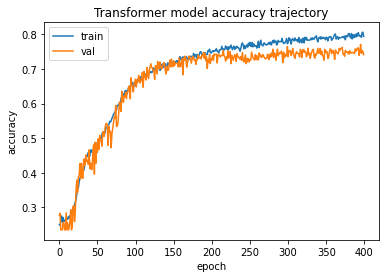

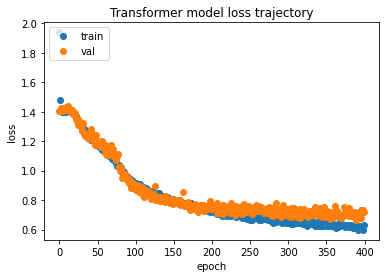

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_transformer.history['accuracy'])
plt.plot(history_transformer.history['val_accuracy'])
plt.title('Transformer model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(history_transformer.history['loss'],'o')
plt.plot(history_transformer.history['val_loss'],'o')
plt.title('Transformer model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [7]:
inputs = layers.Input(shape=(250, 1, 22))

x = layers.Conv2D(filters=50,  kernel_size=(10,1), activation="elu", padding="same")(inputs)
x = layers.MaxPool2D(pool_size=(3,1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)
x = layers.Conv2D(filters=75,  kernel_size=(10,1), activation="elu", padding="same")(x)
x = layers.MaxPool2D(pool_size=(3,1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)
x = layers.Conv2D(filters=100,  kernel_size=(10,1), activation="elu", padding="same")(x)
x = layers.MaxPool2D(pool_size=(3,1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)
x = layers.Conv2D(filters=150, kernel_size=(3,1), activation="elu", padding="same")(x)
x = layers.MaxPool2D(pool_size=(3,1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)
x = layers.Conv2D(filters=200, kernel_size=(3,1), activation="elu", padding="same")(x)
x = layers.MaxPool2D(pool_size=(10,1), padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(dropout)(x)

x = layers.MultiHeadAttention(
    key_dim   = head_size,
    num_heads = num_heads,
    dropout   = 0.7
)(x, x)

x = layers.GlobalMaxPool2D()(x)
softmax_output = layers.Dense(4, activation="softmax", activity_regularizer=tf.keras.regularizers.L2(0.05))(x)

model = keras.Model(inputs, softmax_output)
model.summary()

2023-03-17 09:46:56.493877: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 250, 1, 22)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 250, 1, 50)   11050       ['input_1[0][0]']                
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 84, 1, 50)    0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 84, 1, 50)   200         ['max_pooling2d[0][0]']      

In [8]:
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])
history_transformer = model.fit(subject1_x_train, subject1_y_train, validation_split=0.2, epochs=400, batch_size=64)

Epoch 1/400
10/10 [==============================] - 5s 183ms/step - loss: 1.9560 - accuracy: 0.2579 - val_loss: 2.7075 - val_accuracy: 0.2500
Epoch 2/400
10/10 [==============================] - 1s 130ms/step - loss: 2.3529 - accuracy: 0.2877 - val_loss: 1.7063 - val_accuracy: 0.2125
Epoch 3/400
10/10 [==============================] - 1s 128ms/step - loss: 2.3249 - accuracy: 0.2594 - val_loss: 1.7527 - val_accuracy: 0.2500
Epoch 4/400
10/10 [==============================] - 2s 180ms/step - loss: 2.1912 - accuracy: 0.2752 - val_loss: 1.5207 - val_accuracy: 0.2625
Epoch 5/400
10/10 [==============================] - 2s 152ms/step - loss: 2.1144 - accuracy: 0.2484 - val_loss: 1.3926 - val_accuracy: 0.3063
Epoch 6/400
10/10 [==============================] - 2s 154ms/step - loss: 1.8876 - accuracy: 0.2783 - val_loss: 1.3757 - val_accuracy: 0.3562
Epoch 7/400
10/10 [==============================] - 2s 223ms/step - loss: 1.8090 - accuracy: 0.2311 - val_loss: 1.3836 - val_accuracy: 0.2750

Epoch 58/400
10/10 [==============================] - 1s 146ms/step - loss: 1.3816 - accuracy: 0.2972 - val_loss: 1.5895 - val_accuracy: 0.2625
Epoch 59/400
10/10 [==============================] - 1s 128ms/step - loss: 1.3670 - accuracy: 0.3145 - val_loss: 1.6561 - val_accuracy: 0.2625
Epoch 60/400
10/10 [==============================] - 1s 129ms/step - loss: 1.3564 - accuracy: 0.3538 - val_loss: 1.8053 - val_accuracy: 0.2625
Epoch 61/400
10/10 [==============================] - 1s 127ms/step - loss: 1.3871 - accuracy: 0.2909 - val_loss: 1.5831 - val_accuracy: 0.2625
Epoch 62/400
10/10 [==============================] - 1s 127ms/step - loss: 1.3616 - accuracy: 0.3066 - val_loss: 1.6821 - val_accuracy: 0.2625
Epoch 63/400
10/10 [==============================] - 1s 136ms/step - loss: 1.3492 - accuracy: 0.3255 - val_loss: 1.8862 - val_accuracy: 0.2625
Epoch 64/400
10/10 [==============================] - 2s 165ms/step - loss: 1.3433 - accuracy: 0.3616 - val_loss: 1.7435 - val_accuracy:

Epoch 115/400
10/10 [==============================] - 1s 121ms/step - loss: 0.9658 - accuracy: 0.5425 - val_loss: 1.5396 - val_accuracy: 0.3313
Epoch 116/400
10/10 [==============================] - 1s 122ms/step - loss: 0.9459 - accuracy: 0.5833 - val_loss: 1.3656 - val_accuracy: 0.3750
Epoch 117/400
10/10 [==============================] - 1s 121ms/step - loss: 0.9241 - accuracy: 0.5991 - val_loss: 1.2761 - val_accuracy: 0.4000
Epoch 118/400
10/10 [==============================] - 1s 124ms/step - loss: 0.9441 - accuracy: 0.5991 - val_loss: 1.3287 - val_accuracy: 0.3625
Epoch 119/400
10/10 [==============================] - 1s 122ms/step - loss: 0.9261 - accuracy: 0.5739 - val_loss: 1.2440 - val_accuracy: 0.4125
Epoch 120/400
10/10 [==============================] - 1s 127ms/step - loss: 0.9364 - accuracy: 0.5770 - val_loss: 1.2990 - val_accuracy: 0.3812
Epoch 121/400
10/10 [==============================] - 1s 120ms/step - loss: 0.8990 - accuracy: 0.5928 - val_loss: 1.3925 - val_ac

10/10 [==============================] - 1s 119ms/step - loss: 0.8178 - accuracy: 0.6368 - val_loss: 1.2487 - val_accuracy: 0.4313
Epoch 172/400
10/10 [==============================] - 1s 120ms/step - loss: 0.7510 - accuracy: 0.6635 - val_loss: 1.3378 - val_accuracy: 0.4125
Epoch 173/400
10/10 [==============================] - 1s 120ms/step - loss: 0.7905 - accuracy: 0.6494 - val_loss: 1.3072 - val_accuracy: 0.4375
Epoch 174/400
10/10 [==============================] - 1s 122ms/step - loss: 0.8501 - accuracy: 0.6494 - val_loss: 1.1659 - val_accuracy: 0.4375
Epoch 175/400
10/10 [==============================] - 1s 120ms/step - loss: 0.7989 - accuracy: 0.6494 - val_loss: 1.2082 - val_accuracy: 0.4125
Epoch 176/400
10/10 [==============================] - 1s 122ms/step - loss: 0.7911 - accuracy: 0.6415 - val_loss: 1.1692 - val_accuracy: 0.4437
Epoch 177/400
10/10 [==============================] - 1s 118ms/step - loss: 0.8074 - accuracy: 0.6588 - val_loss: 1.2049 - val_accuracy: 0.4313

10/10 [==============================] - 1s 118ms/step - loss: 0.6981 - accuracy: 0.7091 - val_loss: 0.9961 - val_accuracy: 0.5063
Epoch 228/400
10/10 [==============================] - 1s 120ms/step - loss: 0.6228 - accuracy: 0.7358 - val_loss: 0.9440 - val_accuracy: 0.5500
Epoch 229/400
10/10 [==============================] - 1s 120ms/step - loss: 0.6791 - accuracy: 0.7233 - val_loss: 0.9829 - val_accuracy: 0.5000
Epoch 230/400
10/10 [==============================] - 1s 121ms/step - loss: 0.6919 - accuracy: 0.6981 - val_loss: 1.2295 - val_accuracy: 0.4750
Epoch 231/400
10/10 [==============================] - 1s 120ms/step - loss: 0.7427 - accuracy: 0.7028 - val_loss: 0.7713 - val_accuracy: 0.6125
Epoch 232/400
10/10 [==============================] - 1s 131ms/step - loss: 0.6592 - accuracy: 0.7264 - val_loss: 1.1032 - val_accuracy: 0.4437
Epoch 233/400
10/10 [==============================] - 1s 123ms/step - loss: 0.6594 - accuracy: 0.7484 - val_loss: 0.8043 - val_accuracy: 0.5938

10/10 [==============================] - 1s 121ms/step - loss: 0.5135 - accuracy: 0.8443 - val_loss: 0.5275 - val_accuracy: 0.7875
Epoch 284/400
10/10 [==============================] - 1s 120ms/step - loss: 0.4850 - accuracy: 0.8365 - val_loss: 0.4977 - val_accuracy: 0.8188
Epoch 285/400
10/10 [==============================] - 1s 119ms/step - loss: 0.5668 - accuracy: 0.8097 - val_loss: 0.5434 - val_accuracy: 0.8062
Epoch 286/400
10/10 [==============================] - 1s 120ms/step - loss: 0.5109 - accuracy: 0.8082 - val_loss: 0.4778 - val_accuracy: 0.8188
Epoch 287/400
10/10 [==============================] - 1s 130ms/step - loss: 0.5182 - accuracy: 0.8129 - val_loss: 0.5982 - val_accuracy: 0.7500
Epoch 288/400
10/10 [==============================] - 1s 121ms/step - loss: 0.4792 - accuracy: 0.8113 - val_loss: 0.4311 - val_accuracy: 0.8313
Epoch 289/400
10/10 [==============================] - 1s 126ms/step - loss: 0.4621 - accuracy: 0.8318 - val_loss: 0.3677 - val_accuracy: 0.8687

10/10 [==============================] - 1s 123ms/step - loss: 0.3427 - accuracy: 0.8947 - val_loss: 0.2814 - val_accuracy: 0.9062
Epoch 340/400
10/10 [==============================] - 1s 121ms/step - loss: 0.3946 - accuracy: 0.8726 - val_loss: 0.3014 - val_accuracy: 0.8938
Epoch 341/400
10/10 [==============================] - 1s 121ms/step - loss: 0.3601 - accuracy: 0.8711 - val_loss: 0.2546 - val_accuracy: 0.9125
Epoch 342/400
10/10 [==============================] - 1s 119ms/step - loss: 0.4377 - accuracy: 0.8648 - val_loss: 0.3134 - val_accuracy: 0.8875
Epoch 343/400
10/10 [==============================] - 1s 120ms/step - loss: 0.4124 - accuracy: 0.8585 - val_loss: 0.3655 - val_accuracy: 0.8625
Epoch 344/400
10/10 [==============================] - 1s 123ms/step - loss: 0.4077 - accuracy: 0.8601 - val_loss: 0.4264 - val_accuracy: 0.8188
Epoch 345/400
10/10 [==============================] - 1s 126ms/step - loss: 0.4124 - accuracy: 0.8711 - val_loss: 0.4362 - val_accuracy: 0.8375

10/10 [==============================] - 1s 125ms/step - loss: 0.3017 - accuracy: 0.9167 - val_loss: 0.1863 - val_accuracy: 0.9375
Epoch 396/400
10/10 [==============================] - 1s 123ms/step - loss: 0.3074 - accuracy: 0.9151 - val_loss: 0.2341 - val_accuracy: 0.9312
Epoch 397/400
10/10 [==============================] - 1s 123ms/step - loss: 0.3787 - accuracy: 0.8899 - val_loss: 0.2294 - val_accuracy: 0.9250
Epoch 398/400
10/10 [==============================] - 1s 123ms/step - loss: 0.3205 - accuracy: 0.8899 - val_loss: 0.1410 - val_accuracy: 0.9688
Epoch 399/400
10/10 [==============================] - 1s 121ms/step - loss: 0.3145 - accuracy: 0.9041 - val_loss: 0.1402 - val_accuracy: 0.9688
Epoch 400/400
10/10 [==============================] - 1s 121ms/step - loss: 0.2828 - accuracy: 0.9167 - val_loss: 0.1634 - val_accuracy: 0.9625


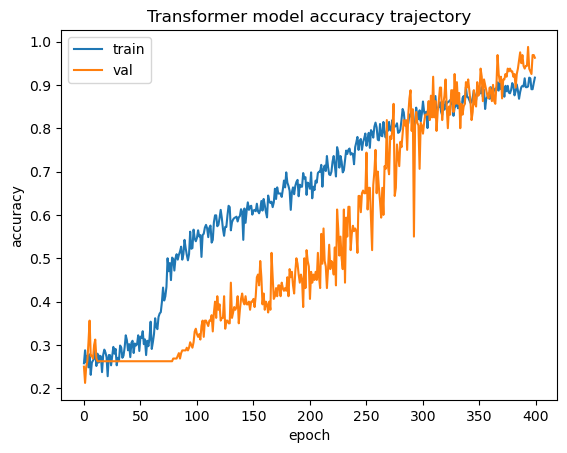

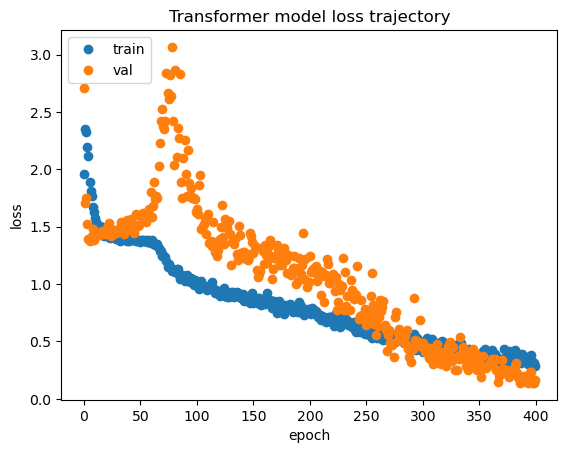

In [26]:
import matplotlib.pyplot as plt

plt.plot(history_transformer.history['accuracy'])
plt.plot(history_transformer.history['val_accuracy'])
plt.title('Transformer model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(history_transformer.history['loss'],'o')
plt.plot(history_transformer.history['val_loss'],'o')
plt.title('Transformer model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [9]:
s_subject1 = model.evaluate(subject1_x_test, subject1_y_test)

7/7 [==============================] - 0s 23ms/step - loss: 1.5385 - accuracy: 0.6950


In [ ]:
dropout  = 0.5

In [14]:
inputs = layers.Input(shape=(250, 1, 22))
x= layers.Conv2D(filters=30, kernel_size=(8,1), padding='same', activation='elu')(inputs)
x=layers.MaxPooling2D(pool_size=(3,1), padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Dropout(dropout)(x)
x=layers.Conv2D(filters=60, kernel_size=(8,1), padding='same', activation='elu')(x)
x=layers.MaxPooling2D(pool_size=(3,1), padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Dropout(dropout)(x)
x=layers.Conv2D(filters=90, kernel_size=(8,1), padding='same', activation='elu')(x)
x=layers.MaxPooling2D(pool_size=(3,1), padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Dropout(dropout)(x)
x=layers.Conv2D(filters=180, kernel_size=(8,1), padding='same', activation='elu')(x)
x=layers.MaxPooling2D(pool_size=(3,1), padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Dropout(dropout)(x)
x=layers.Flatten()(x)
softmax_output = layers.Dense(4, activation="softmax", activity_regularizer=tf.keras.regularizers.L2(0.1))(x)

cnn = keras.Model(inputs, softmax_output)
cnn.summary()







Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 250, 1, 22)]      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 250, 1, 30)        5310      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 84, 1, 30)        0         
 2D)                                                             
                                                                 
 batch_normalization_7 (Batc  (None, 84, 1, 30)        120       
 hNormalization)                                                 
                                                                 
 dropout_6 (Dropout)         (None, 84, 1, 30)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 84, 1, 60)         1446

In [16]:
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="weights_cnn.hdf5",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

cnn.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])
cnn_history = cnn.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=100, batch_size=64,callbacks=[model_checkpoint_callback])


Epoch 1/100
109/109 [==============================] - ETA: 0s - loss: 2.5339 - accuracy: 0.2720
Epoch 1: val_accuracy improved from -inf to 0.37067, saving model to weights_cnn.hdf5
109/109 [==============================] - 11s 79ms/step - loss: 2.5339 - accuracy: 0.2720 - val_loss: 1.3620 - val_accuracy: 0.3707
Epoch 2/100
109/109 [==============================] - ETA: 0s - loss: 1.9193 - accuracy: 0.2927
Epoch 2: val_accuracy did not improve from 0.37067
109/109 [==============================] - 8s 75ms/step - loss: 1.9193 - accuracy: 0.2927 - val_loss: 1.4021 - val_accuracy: 0.2940
Epoch 3/100
109/109 [==============================] - ETA: 0s - loss: 1.6259 - accuracy: 0.3098
Epoch 3: val_accuracy did not improve from 0.37067
109/109 [==============================] - 10s 91ms/step - loss: 1.6259 - accuracy: 0.3098 - val_loss: 1.4526 - val_accuracy: 0.2960
Epoch 4/100
109/109 [==============================] - ETA: 0s - loss: 1.4930 - accuracy: 0.3167
Epoch 4: val_accuracy did 

Epoch 29/100
108/109 [============================>.] - ETA: 0s - loss: 1.0385 - accuracy: 0.5877
Epoch 29: val_accuracy did not improve from 0.61067
109/109 [==============================] - 7s 65ms/step - loss: 1.0377 - accuracy: 0.5876 - val_loss: 1.0605 - val_accuracy: 0.5720
Epoch 30/100
109/109 [==============================] - ETA: 0s - loss: 1.0263 - accuracy: 0.5978
Epoch 30: val_accuracy improved from 0.61067 to 0.61533, saving model to weights_cnn.hdf5
109/109 [==============================] - 8s 74ms/step - loss: 1.0263 - accuracy: 0.5978 - val_loss: 1.0021 - val_accuracy: 0.6153
Epoch 31/100
109/109 [==============================] - ETA: 0s - loss: 1.0102 - accuracy: 0.6034
Epoch 31: val_accuracy did not improve from 0.61533
109/109 [==============================] - 7s 65ms/step - loss: 1.0102 - accuracy: 0.6034 - val_loss: 0.9935 - val_accuracy: 0.6147
Epoch 32/100
108/109 [============================>.] - ETA: 0s - loss: 0.9837 - accuracy: 0.6209
Epoch 32: val_accu

Epoch 57/100
108/109 [============================>.] - ETA: 0s - loss: 0.8557 - accuracy: 0.6840
Epoch 57: val_accuracy did not improve from 0.68667
109/109 [==============================] - 8s 72ms/step - loss: 0.8559 - accuracy: 0.6839 - val_loss: 0.8852 - val_accuracy: 0.6513
Epoch 58/100
109/109 [==============================] - ETA: 0s - loss: 0.8501 - accuracy: 0.6851
Epoch 58: val_accuracy did not improve from 0.68667
109/109 [==============================] - 9s 85ms/step - loss: 0.8501 - accuracy: 0.6851 - val_loss: 0.8627 - val_accuracy: 0.6593
Epoch 59/100
109/109 [==============================] - ETA: 0s - loss: 0.8498 - accuracy: 0.6865
Epoch 59: val_accuracy did not improve from 0.68667
109/109 [==============================] - 8s 77ms/step - loss: 0.8498 - accuracy: 0.6865 - val_loss: 0.8604 - val_accuracy: 0.6760
Epoch 60/100
109/109 [==============================] - ETA: 0s - loss: 0.8420 - accuracy: 0.6874
Epoch 60: val_accuracy did not improve from 0.68667
109/

Epoch 86/100
108/109 [============================>.] - ETA: 0s - loss: 0.7761 - accuracy: 0.7211
Epoch 86: val_accuracy did not improve from 0.70000
109/109 [==============================] - 9s 84ms/step - loss: 0.7768 - accuracy: 0.7210 - val_loss: 0.8453 - val_accuracy: 0.6807
Epoch 87/100
108/109 [============================>.] - ETA: 0s - loss: 0.7625 - accuracy: 0.7263
Epoch 87: val_accuracy did not improve from 0.70000
109/109 [==============================] - 7s 62ms/step - loss: 0.7626 - accuracy: 0.7261 - val_loss: 0.8833 - val_accuracy: 0.6673
Epoch 88/100
109/109 [==============================] - ETA: 0s - loss: 0.7711 - accuracy: 0.7191
Epoch 88: val_accuracy did not improve from 0.70000
109/109 [==============================] - 7s 62ms/step - loss: 0.7711 - accuracy: 0.7191 - val_loss: 0.8596 - val_accuracy: 0.6853
Epoch 89/100
108/109 [============================>.] - ETA: 0s - loss: 0.7805 - accuracy: 0.7143
Epoch 89: val_accuracy did not improve from 0.70000
109/

In [20]:
cnn.load_weights("weights_cnn.hdf5")
s = cnn.evaluate(x_test, y_test)



56/56 [==============================] - 1s 16ms/step - loss: 0.8048 - accuracy: 0.7015


In [21]:
cnn_subject1=cnn.evaluate(subject1_x_test,subject1_y_test)

7/7 [==============================] - 0s 13ms/step - loss: 0.8864 - accuracy: 0.6500


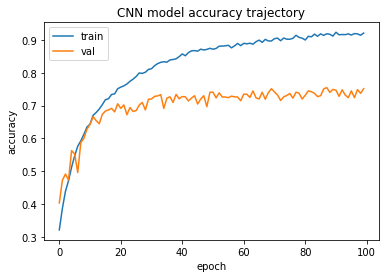

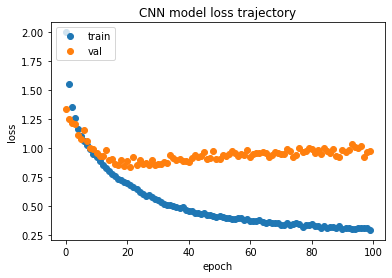

In [ ]:
import matplotlib.pyplot as plt

plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(cnn_history.history['loss'],'o')
plt.plot(cnn_history.history['val_loss'],'o')
plt.title('CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
dropout = 0.5

In [ ]:
inputs = layers.Input(shape=(250, 1, 22))
x= layers.Conv2D(filters=30, kernel_size=(8,1), padding='same', activation='elu')(inputs)
x=layers.MaxPooling2D(pool_size=(3,1), padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Dropout(dropout)(x)
x=layers.Conv2D(filters=60, kernel_size=(8,1), padding='same', activation='elu')(x)
x=layers.MaxPooling2D(pool_size=(3,1), padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Dropout(dropout)(x)
x=layers.Conv2D(filters=90, kernel_size=(8,1), padding='same', activation='elu')(x)
x=layers.MaxPooling2D(pool_size=(3,1), padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Dropout(dropout)(x)
x=layers.Conv2D(filters=180, kernel_size=(8,1), padding='same', activation='elu')(x)
x=layers.MaxPooling2D(pool_size=(3,1), padding='same')(x)
x=layers.BatchNormalization()(x)
x=layers.Dropout(dropout)(x)
x=layers.Flatten()(x)
softmax_output = layers.Dense(4, activation="softmax", activity_regularizer=tf.keras.regularizers.L2(0.01))(x)

cnn2 = keras.Model(inputs, softmax_output)
cnn2.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 250, 1, 22)]      0         
                                                                 
 conv2d_26 (Conv2D)          (None, 250, 1, 30)        5310      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 84, 1, 30)        0         
 g2D)                                                            
                                                                 
 batch_normalization_26 (Bat  (None, 84, 1, 30)        120       
 chNormalization)                                                
                                                                 
 dropout_24 (Dropout)        (None, 84, 1, 30)         0         
                                                                 
 conv2d_27 (Conv2D)          (None, 84, 1, 60)         1446

In [ ]:
cnn2.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-3), metrics=["accuracy"])
cnn_history_subject1 = cnn2.fit(subject1_x_train, subject1_y_train, validation_split=0.2, epochs=100, batch_size=64)



Epoch 1/100
10/10 [==============================] - 3s 50ms/step - loss: 2.3541 - accuracy: 0.2642 - val_loss: 6.2419 - val_accuracy: 0.2500
Epoch 2/100
10/10 [==============================] - 0s 15ms/step - loss: 1.8753 - accuracy: 0.3726 - val_loss: 5.4963 - val_accuracy: 0.2625
Epoch 3/100
10/10 [==============================] - 0s 16ms/step - loss: 1.8619 - accuracy: 0.3695 - val_loss: 3.3523 - val_accuracy: 0.3313
Epoch 4/100
10/10 [==============================] - 0s 16ms/step - loss: 1.5989 - accuracy: 0.4465 - val_loss: 3.1059 - val_accuracy: 0.3313
Epoch 5/100
10/10 [==============================] - 0s 16ms/step - loss: 1.4955 - accuracy: 0.4764 - val_loss: 3.0252 - val_accuracy: 0.3125
Epoch 6/100
10/10 [==============================] - 0s 15ms/step - loss: 1.3988 - accuracy: 0.5079 - val_loss: 2.5689 - val_accuracy: 0.3313
Epoch 7/100
10/10 [==============================] - 0s 16ms/step - loss: 1.3549 - accuracy: 0.5220 - val_loss: 1.7672 - val_accuracy: 0.4125
Epoch 

In [ ]:
s_subject1 = cnn2.evaluate(subject1_x_test, subject1_y_test)

7/7 [==============================] - 0s 7ms/step - loss: 1.6029 - accuracy: 0.6550


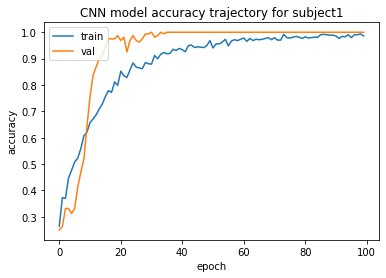

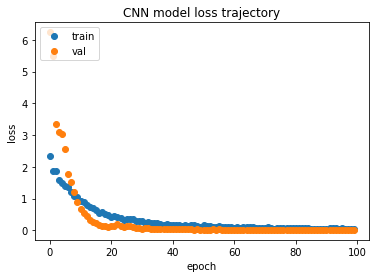

In [ ]:
plt.plot(cnn_history_subject1.history['accuracy'])
plt.plot(cnn_history_subject1.history['val_accuracy'])
plt.title('CNN model accuracy trajectory for subject1')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(cnn_history_subject1.history['loss'],'o')
plt.plot(cnn_history_subject1.history['val_loss'],'o')
plt.title('CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
dropout = 0.6

In [ ]:
inputs = layers.Input(shape=(250, 1, 22))

x = layers.Conv2D(filters=25,  kernel_size=(10,1), activation="elu", padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=50,  kernel_size=(10,1), activation="elu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D(pool_size=(10,1))(x)
x = layers.Dropout(dropout)(x)
x = layers.Reshape(target_shape=(25,50))(x)
x = layers.LSTM(128, recurrent_dropout=dropout, return_sequences=True)(x)
x = layers.LSTM(256, recurrent_dropout=dropout)(x)
x = layers.Dense(4, activation="softmax", activity_regularizer=tf.keras.regularizers.L2(0.2))(x)
model = keras.Model(inputs, x)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 250, 1, 22)]      0         
                                                                 
 conv2d_30 (Conv2D)          (None, 250, 1, 25)        5525      
                                                                 
 batch_normalization_30 (Bat  (None, 250, 1, 25)       100       
 chNormalization)                                                
                                                                 
 conv2d_31 (Conv2D)          (None, 250, 1, 50)        12550     
                                                                 
 batch_normalization_31 (Bat  (None, 250, 1, 50)       200       
 chNormalization)                                                
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 25, 1, 50)        0   

In [ ]:
import time

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="weights_lstm.hdf5",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

start = time.time()
model.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=["accuracy"])
lstm_history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=40, batch_size=64, callbacks=[model_checkpoint_callback])
end = time.time()
wall_time_lstm = end - start

Epoch 1/40
109/109 [==============================] - ETA: 0s - loss: 1.4207 - accuracy: 0.3052
Epoch 1: val_accuracy improved from -inf to 0.30667, saving model to weights_lstm.hdf5
109/109 [==============================] - 31s 234ms/step - loss: 1.4207 - accuracy: 0.3052 - val_loss: 1.4089 - val_accuracy: 0.3067
Epoch 2/40
109/109 [==============================] - ETA: 0s - loss: 1.3654 - accuracy: 0.3774
Epoch 2: val_accuracy improved from 0.30667 to 0.39067, saving model to weights_lstm.hdf5
109/109 [==============================] - 23s 207ms/step - loss: 1.3654 - accuracy: 0.3774 - val_loss: 1.3432 - val_accuracy: 0.3907
Epoch 3/40
109/109 [==============================] - ETA: 0s - loss: 1.3006 - accuracy: 0.4328
Epoch 3: val_accuracy improved from 0.39067 to 0.40333, saving model to weights_lstm.hdf5
109/109 [==============================] - 22s 204ms/step - loss: 1.3006 - accuracy: 0.4328 - val_loss: 1.3469 - val_accuracy: 0.4033
Epoch 4/40
109/109 [=======================

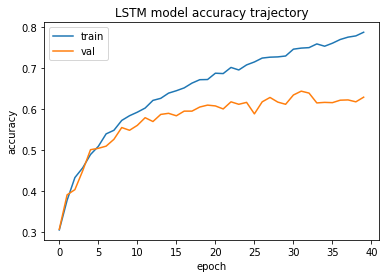

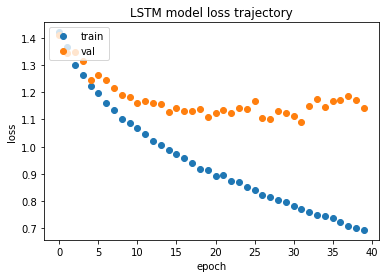

In [ ]:
import matplotlib.pyplot as plt

plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(lstm_history.history['loss'],'o')
plt.plot(lstm_history.history['val_loss'],'o')
plt.title('LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
lstm_eval = model.evaluate(x_test, y_test)


56/56 [==============================] - 1s 17ms/step - loss: 1.1892 - accuracy: 0.6225


In [22]:
lstm_subject1=model.evaluate(subject1_x_test,subject1_y_test)

7/7 [==============================] - 0s 29ms/step - loss: 1.5385 - accuracy: 0.6950


In [10]:
inputs = layers.Input(shape=(250, 1, 22))

x = layers.Conv2D(filters=25,  kernel_size=(10,1), activation="elu", padding="same")(inputs)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(filters=50,  kernel_size=(10,1), activation="elu", padding="same")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPool2D(pool_size=(10,1))(x)
x = layers.Dropout(dropout)(x)
x = layers.Reshape(target_shape=(25,50))(x)
x = layers.LSTM(128, recurrent_dropout=dropout, return_sequences=True)(x)
x = layers.LSTM(256, recurrent_dropout=dropout)(x)
x = layers.Dense(4, activation="softmax", activity_regularizer=tf.keras.regularizers.L2(0.2))(x)
lstm_subject1 = keras.Model(inputs, x)
lstm_subject1.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 250, 1, 22)]      0         
                                                                 
 conv2d_5 (Conv2D)           (None, 250, 1, 25)        5525      
                                                                 
 batch_normalization_5 (Batc  (None, 250, 1, 25)       100       
 hNormalization)                                                 
                                                                 
 conv2d_6 (Conv2D)           (None, 250, 1, 50)        12550     
                                                                 
 batch_normalization_6 (Batc  (None, 250, 1, 50)       200       
 hNormalization)                                                 
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 25, 1, 50)        0   

In [12]:
lstm_subject1.compile(loss="categorical_crossentropy", optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=["accuracy"])
lstm_history = lstm_subject1.fit(subject1_x_train, subject1_y_train, validation_split=0.2, epochs=40, batch_size=64)

Epoch 1/40
10/10 [==============================] - 12s 463ms/step - loss: 1.4326 - accuracy: 0.2814 - val_loss: 1.4331 - val_accuracy: 0.2688
Epoch 2/40
10/10 [==============================] - 4s 364ms/step - loss: 1.4335 - accuracy: 0.2893 - val_loss: 1.4350 - val_accuracy: 0.3125
Epoch 3/40
10/10 [==============================] - 3s 337ms/step - loss: 1.4267 - accuracy: 0.2893 - val_loss: 1.4299 - val_accuracy: 0.3562
Epoch 4/40
10/10 [==============================] - 3s 303ms/step - loss: 1.4226 - accuracy: 0.3035 - val_loss: 1.4301 - val_accuracy: 0.3938
Epoch 5/40
10/10 [==============================] - 3s 299ms/step - loss: 1.4146 - accuracy: 0.3145 - val_loss: 1.4137 - val_accuracy: 0.3750
Epoch 6/40
10/10 [==============================] - 4s 393ms/step - loss: 1.4099 - accuracy: 0.3223 - val_loss: 1.4048 - val_accuracy: 0.4500
Epoch 7/40
10/10 [==============================] - 4s 379ms/step - loss: 1.3894 - accuracy: 0.3664 - val_loss: 1.4011 - val_accuracy: 0.4125
Epoch

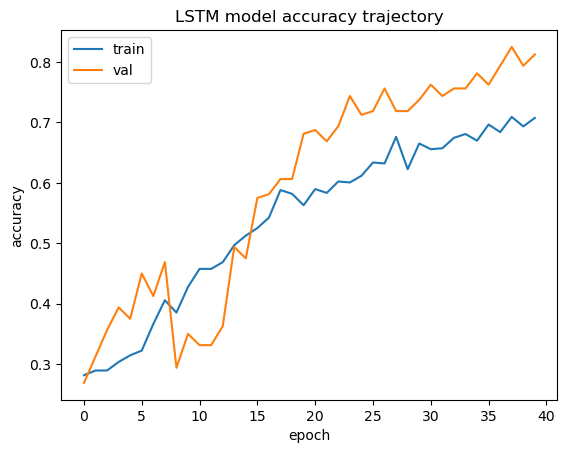

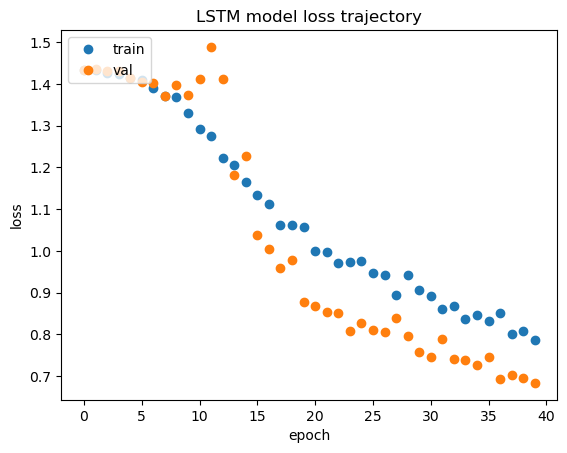

In [25]:
import matplotlib.pyplot as plt

plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('LSTM model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(lstm_history.history['loss'],'o')
plt.plot(lstm_history.history['val_loss'],'o')
plt.title('LSTM model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [13]:
lstm_subject1_eval = lstm_subject1.evaluate(subject1_x_test, subject1_y_test)

7/7 [==============================] - 1s 76ms/step - loss: 1.4455 - accuracy: 0.5550


# Accuracy and Loss Trajectory - See CNN preprocessing notebook
# Wall Time Analysis